Here, we will read in the values for the fit parameters from R and plot the fits compared to the data for each experiment.

In [1]:
import numpy as np
import pandas as pd

from scipy.special import hyp2f1

import matplotlib.pyplot as plt
#%matplotlib inline

In [2]:
# Read in all data. Note counts == concentration, since sample size is 1 L
fn = 'eDNA_'
# fish was put at time 0, and then the flow rate was changed every two hours
fr = pd.read_csv(fn+'Data.xlsx - FlowRate Data.csv')
# fish was put in for four hours and measurements after 10 min, 30 min, 1h, 2h and 4h. 
# removed the fish and measured over the course of 1 week (1, 2, 4 and 7 days after fish first introduced).
# For 4h mark, data was after removing the fish, 10 minutes after the fish removal
# Multiple measurements at each time step
sc = pd.read_csv(fn+'Data.xlsx - Static.csv')

In [3]:
# Define labels. This is so that if the headers change the code can still run
fish_fr = 'Organism'
time_fr = 'Hours'
copies_fr = 'Copies1Lsc'

fish_sc = 'BioRep'
time_sc = 'Hours'
copies_sc = 'eDNA1Lsc'
copies_scR = 'eRNA1Lsc'

labels_fr = [fish_fr,time_fr,copies_fr] # Keep in minutes because of flow rate
labels_sc = [fish_sc,time_sc,copies_sc]
labels_scR = [fish_sc,time_sc,copies_scR]

In [4]:
# Now read in fits
fr_fit = pd.read_csv("flow_rate_fits.csv")
sc_fit_vol = pd.read_csv("static_tank_fits_volume.csv")
sc_fit_dna = pd.read_csv("static_tank_fits_eDNA.csv")
sc_fit_rna = pd.read_csv("static_tank_fits_eRNA.csv")

# Plot fit data

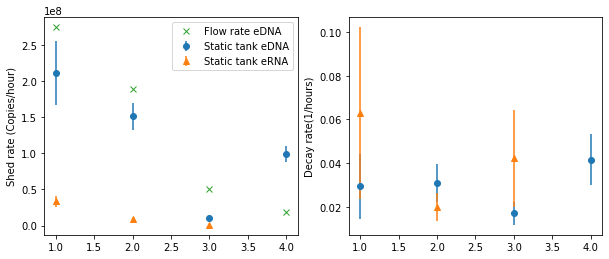

In [6]:
# Plot the fit data directly
fix,axs = plt.subplots(1,2,figsize=(10,4))
# Plot shed rates
axs[0].errorbar([1,2,3,4],sc_fit_dna['s'],fmt='o',yerr=sc_fit_dna['serr'],label='Static tank eDNA')
axs[0].errorbar([1,2,3],sc_fit_rna['s'],fmt='^',yerr=sc_fit_rna['serr'],label='Static tank eRNA')
axs[0].plot([1,2,3,4],fr_fit['s'],'x',label='Flow rate eDNA')
axs[0].set_ylabel('Shed rate (Copies/hour)')
# Plot decay rates
axs[1].errorbar([1,2,3,4],sc_fit_dna['k'],fmt='o',yerr=sc_fit_dna['kerr'],label='Static tank eDNA')
axs[1].errorbar([1,2,3],sc_fit_rna['k'],fmt='^',yerr=sc_fit_rna['kerr'],label='Static tank eRNA')
axs[1].set_ylabel('Decay rate(1/hours)')

axs[0].legend()

# Flow rate

In [7]:
# Now define separate models for each case
def fr_model(t,p,df):
    s=np.exp(p['S'])
    k=np.exp(p['k']) # To keep it positive
    # Get volume. It should be constant.
    v = 285# df['Volume'].mean() # Override reading it in.
    # Get flow rates in appropriate units
    uvec = df['Flow'].unique()/v*60 # In L/hour (with the *60)
    # This I'm just going to set by hand. It's the amount of time between changing flow rates.
    tl = 2# in hours
    
    # Get initial concentrations for each of the 4 sections
    # Actual initial c0
    c = np.zeros(len(uvec))
    # Constant term in solution c0
    cp = np.zeros(len(uvec))
    for i in np.arange(len(uvec)):
        if i==0:
            # Set the 0 case
            c[0] = df[df[time_fr]==0][copies_fr]
            #cp[0] = c[0]-p['S']/v/(p['k']+uvec[0])
            cp[0] = c[0]-s/v/(k+uvec[0])
        else:
            #c[i] = np.exp(-(p['k']+uvec[i-1])*tl)*cp[i-1]+p['S']/v/(p['k']+uvec[i-1])
            #cp[i] = c[i]-p['S']/v/(p['k']+uvec[i])
            c[i] = np.exp(-(k+uvec[i-1])*tl)*cp[i-1]+s/v/(k+uvec[i-1])
            cp[i] = c[i]-s/v/(k+uvec[i])
    # Define return variable
    ct = 0
    if t<=tl:
        ct = np.exp(-(k+uvec[0])*t)*cp[0]+s/v/(k+uvec[0])
        #ct = np.exp(-(p['k']+uvec[0])*t)*cp[0]+p['S']/v/(p['k']+uvec[0])
    elif t<=2*tl:
        ct = np.exp(-(k+uvec[1])*(t-tl))*cp[1]+s/v/(k+uvec[1])
        #ct = np.exp(-(p['k']+uvec[1])*(t-tl))*cp[1]+p['S']/v/(p['k']+uvec[1])
    elif t<=3*tl:
        ct = np.exp(-(k+uvec[2])*(t-2*tl))*cp[2]+s/v/(k+uvec[2])
        #ct = np.exp(-(p['k']+uvec[2])*(t-2*tl))*cp[2]+p['S']/v/(p['k']+uvec[2])
    elif t>3*tl:
        ct = np.exp(-(k+uvec[3])*(t-3*tl))*cp[3]+s/v/(k+uvec[3])
        #ct = np.exp(-(p['k']+uvec[3])*(t-3*tl))*cp[3]+p['S']/v/(p['k']+uvec[3])
    return ct
        
fr_vec = np.vectorize(fr_model,excluded=[2,3]) # Have to exclude df

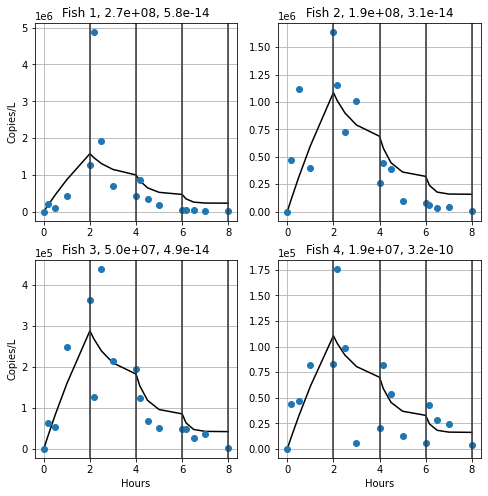

In [8]:
fig,axs = plt.subplots(2,2,figsize=(8,8))
for f,ax in zip(fr[fish_fr].unique(),axs.ravel()):
    # Data for each fish
    frt = fr[fr[fish_fr]==f]
    s = fr_fit.loc[f-1,'s']
    k = fr_fit.loc[f-1,'k']
    # Plot also
    ax.set_title('Fish {}, {:.1e}, {:.1e}'.format(f,s,k))
    # Theory
    ax.plot(frt[time_fr],fr_vec(frt[time_fr],{'S':np.log(s),'k':np.log(k)},frt),c='k')
    # Measured
    ax.plot(frt[time_fr],frt[copies_fr],'o')
    for i in np.arange(4):
        ax.axvline(2*(i+1),color='0.2')
    ax.grid(True)
    ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
# Labels
axs[0,0].set_ylabel("Copies/L")
axs[1,0].set_ylabel("Copies/L")
axs[1,0].set_xlabel(time_fr)
axs[1,1].set_xlabel(time_fr)
fig.savefig('FlowRate_fits.pdf')

# Static experiment

## eDNA

In [9]:
# time fish is removed. Could maybe be 240, then measurement is actually at 250?
tf_sc = 230/60 # Convert to hours

In [10]:
# Find how volume changes over time
# Assume this functional form
def vfunc_sc(t,p0,p1,p2):
    '''p are params, t is time'''
    return p0*np.exp(-p1*t)+p2

# If this is the functional form, the solution is:
def sc_model(t,p,df,f,pvf,RNA=False):
    # the RNA tag is if we want to do the eRNA decay
    s=np.exp(p['S'])
    k=np.exp(p['k'])
    pv = pvf.loc[f-1] # Have to pass in array of all fish, select the relevant one.
    # Get initial concentration
    c0=0
    if RNA:
        c0=df[df[time_sc]==0][copies_scR].mean()
    else:
        c0=df[df[time_sc]==0][copies_sc].mean()
    # Assuming vfunc functional form, fit parameters for that
    # Pass in fit values, it's much easier.
    #pv,errv = optimize.curve_fit(vfunc_sc,df['Time (min)'],df['Tank V (L)'],p0=(480,0.1,300))
    if t<=tf_sc:
        # Write complicated terms
        hypt1 = np.exp((pv[1]+k)*t)*hyp2f1(1,1+k/pv[1],2+k/pv[1],-pv[2]*np.exp(pv[1]*t)/pv[0])
        hypt2 = hyp2f1(1,1+k/pv[1],2+k/pv[1],-pv[2]/pv[0])
        hypt = (hypt1-hypt2)/(pv[0]*(pv[1]+k))
    elif t>tf_sc:
        hypt1 = np.exp((pv[1]+k)*tf_sc)*hyp2f1(1,1+k/pv[1],2+k/pv[1],-pv[2]*np.exp(pv[1]*tf_sc)/pv[0])
        hypt2 = hyp2f1(1,1+k/pv[1],2+k/pv[1],-pv[2]/pv[0])
        hypt = (hypt1-hypt2)/(pv[0]*(pv[1]+k)) 
    return np.exp(-k*t)*c0+np.exp(-k*t)*hypt*s

sc_vec = np.vectorize(sc_model,excluded=[2,3,4,5])

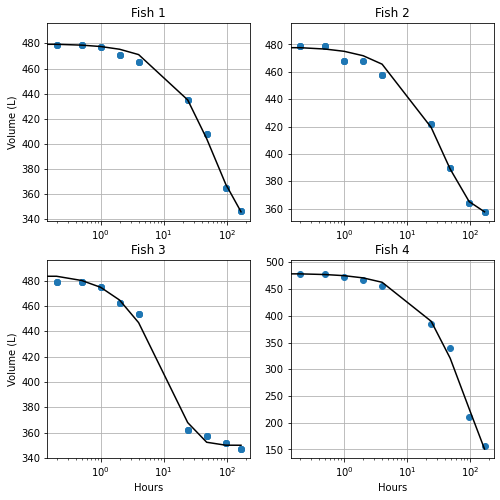

In [11]:
fig,axs = plt.subplots(2,2,figsize=(8,8))
for f,ax in zip(sc[fish_sc].unique(),axs.ravel()):
    # Plot each volume
    sct = sc[sc[fish_sc]==f]
    tt = sct[time_sc]
    vt = sct['Volume']
    #pt,errt = optimize.curve_fit(vfunc_sc,tt,vt,p0=(480,0.1,300))
    #p_sc.append(pt)
    # Plot also
    ax.set_title('Fish {}'.format(f))
    ax.semilogx(tt,vt,'o')
    ax.semilogx(tt.unique(),
                vfunc_sc(tt.unique(),sc_fit_vol.loc[f-1,'p1'],sc_fit_vol.loc[f-1,'p2'],sc_fit_vol.loc[f-1,'p3']),'k')
    ax.grid(True)
# Labels
axs[0,0].set_ylabel('Volume (L)')
axs[1,0].set_ylabel('Volume (L)')
axs[1,0].set_xlabel(time_sc)
axs[1,1].set_xlabel(time_sc)
fig.savefig('Static_volume.pdf')

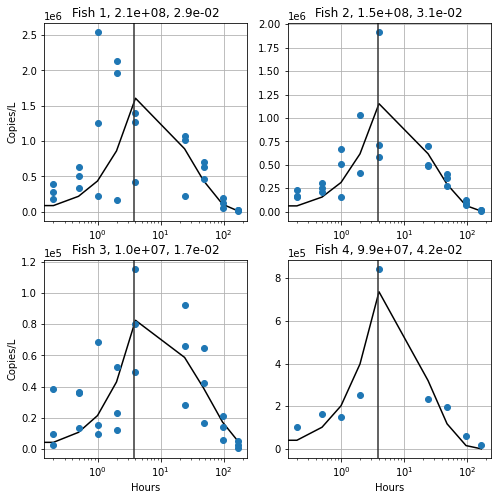

In [12]:
fig,axs = plt.subplots(2,2,figsize=(8,8))
for f,ax in zip(sc[fish_sc].unique(),axs.ravel()):
    # Plot each fish
    sct = sc[sc[fish_sc]==f]
    s = sc_fit_dna.loc[f-1,'s']
    k = sc_fit_dna.loc[f-1,'k']
    ax.set_title('Fish {}, {:.1e}, {:.1e}'.format(f,s,k))
    ax.semilogx(sct[time_sc],sc_vec(sct[time_sc],
                                         {'S':np.log(s),'k':np.log(k)},sct,f,sc_fit_vol),c='k')
    ax.semilogx(sct[time_sc],sct[copies_sc],'o')
    ax.axvline(tf_sc,color='0.2')
    ax.grid(True)
    ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
# Labels
axs[0,0].set_ylabel("Copies/L")
axs[1,0].set_ylabel("Copies/L")
axs[1,0].set_xlabel(time_sc)
axs[1,1].set_xlabel(time_sc)

fig.savefig('Static_eDNA.pdf')

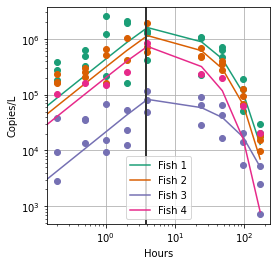

In [13]:
# On one plot
# Get colormap
cs = [plt.cm.Dark2(i) for i in np.arange(4)]
fig,ax = plt.subplots(figsize=(4,4))
for i,f in enumerate(sc[fish_sc].unique()):
    # Plot each fish
    sct = sc[sc[fish_sc]==f]
    s = sc_fit_dna.loc[f-1,'s']
    k = sc_fit_dna.loc[f-1,'k']
    # Plot also
    lab = 'Fish {}'.format(f)
    ax.loglog(sct[time_sc],sc_vec(sct[time_sc],
                                         {'S':np.log(s),'k':np.log(k)},sct,f,sc_fit_vol),c=cs[i],label=lab)
    ax.loglog(sct[time_sc],sct[copies_sc],'o',c=cs[i])
    ax.axvline(tf_sc,color='0.2')
    ax.grid(True)
# Labels
ax.set_ylabel("Copies/L")
ax.set_xlabel(time_sc)
ax.legend()

fig.savefig('Static_eDNA_oneplot.pdf')

## eRNA

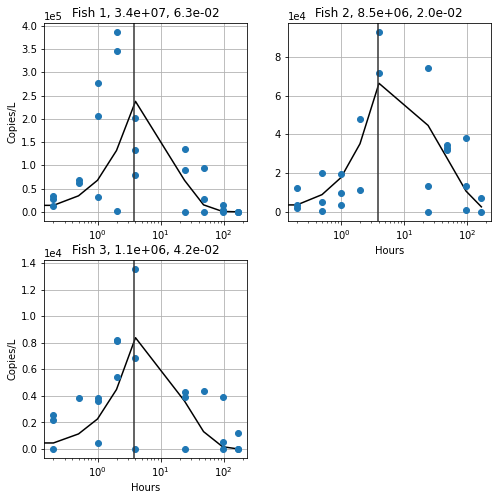

In [14]:
fig,axs = plt.subplots(2,2,figsize=(8,8))
for f,ax in zip(sc[fish_sc].unique()[0:-1],axs.ravel()):
    # Plot each fish
    sct = sc[sc[fish_sc]==f]
    s = sc_fit_rna.loc[f-1,'s']
    k = sc_fit_rna.loc[f-1,'k']
    # Plot also
    ax.set_title('Fish {}, {:.1e}, {:.1e}'.format(f,s,k))
    ax.semilogx(sct[time_sc],sc_vec(sct[time_sc],
                                         {'S':np.log(s),'k':np.log(k)},sct,f,sc_fit_vol,RNA=True),c='k')
    ax.semilogx(sct[time_sc],sct[copies_scR],'o')
    ax.axvline(tf_sc,color='0.2')
    ax.grid(True)
    ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
# Labels
axs[0,0].set_ylabel("Copies/L")
axs[1,0].set_ylabel("Copies/L")
axs[1,0].set_xlabel(time_sc)
axs[0,1].set_xlabel(time_sc)
# Remove 4th one
axs[1,1].set_visible(False)
fig.savefig("Static_eRNA.pdf")

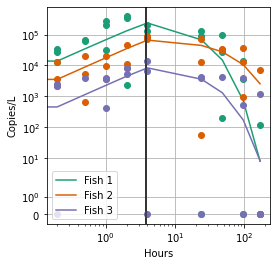

In [15]:
# On one plot
# Get colormap
cs = [plt.cm.Dark2(i) for i in np.arange(4)]
fig,ax = plt.subplots(figsize=(4,4))
for i,f in enumerate(sc[fish_sc].unique()[0:-1]):
    # Plot each fish
    sct = sc[sc[fish_sc]==f]
    s = sc_fit_rna.loc[f-1,'s']
    k = sc_fit_rna.loc[f-1,'k']
    # Plot also
    lab = 'Fish {}'.format(f)
    ax.loglog(sct[time_sc],sc_vec(sct[time_sc],
                                         {'S':np.log(s),'k':np.log(k)},sct,f,sc_fit_vol,RNA=True),c=cs[i],label=lab)
    ax.loglog(sct[time_sc],sct[copies_scR],'o',c=cs[i])
    ax.axvline(tf_sc,color='0.2')
    ax.grid(True)
    ax.set_yscale('symlog') # To show zeros
# Labels
ax.set_ylabel("Copies/L")
ax.set_xlabel(time_sc)
ax.legend()

# Remove 4th one
axs[1,1].set_visible(False)
fig.savefig("Static_eRNA_oneplot.pdf")